### Sector Rotation strategy with momentum
Use Index of representative asset classes  
Market Index ETF, sector etf, bond etf are included  
Result is driven from 2010 to 2021 market data  

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

In [23]:
import quantstats
from scipy.optimize import minimize

In [24]:
start_date='2006-01-01'
end_date='2022-09-01'
cost=0.001

In [25]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/c/workspace/asset_allocation_strategy/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/c/workspace/asset_allocation_strategy
changed directory is :  /mnt/c/workspace/asset_allocation_strategy


In [26]:
from backtest.backtest_engine import BacktestEngine
from backtest.target_generator import TargetGenerator

In [27]:
from benchmark_strategy.equal_weight import EqualWeightGenerator
from benchmark_strategy._60_40_allocation import _60_40_allocation

#### Load Data of each asset classes
Use representative ETF to model strategy  
Data should be in yld format   
[rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [28]:
class SectorRotation(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)
    
    def compute_target(self, universe_list):
        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        date = engine.date
        target_weight = {}
        target_weight =  self.compute_factor(date = date, tickers=universe_list)

        return target_weight
    
    def compute_factor(self, date, tickers):
        """
        to calculate r
        :param covariance_matrix: covariance matrix of assets in universe
        :return: [list] weight of risk parity investment strategy
        """
        date_12_month_lag = date - relativedelta(months=12)
        return_df = pd.DataFrame()
        for ticker in tickers:
            asset_series = self.cache['index'][ticker]['closeadj']
            asset_series.rename(ticker, inplace=True)
            return_df[ticker] = asset_series

        return_df = return_df.loc[date_12_month_lag : date]
        return_df =  return_df.pct_change().fillna(0)

        target = {} 
        result = self.sector_momentum(return_df)
        for ticker in return_df.columns:
            target[ticker] = result.loc[date, ticker]

        return target

    def get_momentum(self, yld_df):
        """
        calculate momentum of sectors. use 12 month, 6 month, 3 month momentum to bit market
        input
        yiled_df : dataframe with weekly yield of asset classes

        returns : momentum in pandas dataframe format. momentum of each asset classes for give date
        """
        momentum = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
        
        windows = 250
        for ticker in yld_df.columns:
            i = 0 
            for date in yld_df.index:
                # 250 days before = 1 year  before
                if i > windows :
                    # first 12 month data (52 data points) cannot be used since 12 month lagged returns is required
                    momentum.loc[date, ticker] = yld_df[ticker].iloc[i] / yld_df[ticker].iloc[i - windows] - 1
                else:
                    momentum.loc[date, ticker] = 0
                i = i + 1

        momentum = momentum.replace([np.inf], 1000)
        momentum = momentum.replace([-np.inf], -1000)
        momentum = momentum.replace([np.nan], 0)
        return momentum

    def select_sector(self, yld_df):
        """
        select top 5 sectors with highest momentum score
        returns: selected_tickers in list format. list with top 5 momentum in given period`
        """
        # inherit previous method and run
        momentum_df = self.get_momentum(yld_df)
        selected_momentum = pd.DataFrame(
            columns=['momentum_1','momentum_2','momentum_3','momentum_4','momentum_5'],
            index=momentum_df.index
        )
        selected_ticker = pd.DataFrame(
            columns=['momentum_1','momentum_2','momentum_3','momentum_4','momentum_5'],
            index=momentum_df.index
        )
        for date in momentum_df.index:
            sorted_momentum = momentum_df.loc[date].sort_values(ascending=False)
            for i in range(len(selected_momentum.columns)):
                selected_momentum.loc[date,f'momentum_{i+1}'] = sorted_momentum[i]
                selected_ticker.loc[date,f'momentum_{i+1}'] = sorted_momentum.index[i]
        return selected_ticker

    def sector_momentum(self, yld_df):
        """
        returns : market portfolio in pandas dataframe format.
        """
        # inherit previous method and run
        # select_sector method returns tickers
        mom_ticker_df = self.select_sector(yld_df)
        # print(mom_ticker_df)
        mp_table = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
        for date in yld_df.index:
            selected = mom_ticker_df.loc[date].tolist()
            for sel in selected:
                mp_table.loc[date, sel] = 1/len(selected)
        mp_table = mp_table.fillna(0)
        return mp_table


In [29]:
custom_universe =[
    "XLB",  # The Materials Select Sector SPDR® Fund                1998-12-16
    "XLE",  # The Energy Select Sector SPDR® Fund                   1998-12-22
    "XLF",  # The Financial Select Sector SPDR® Fund                1998-12-22
    "XLI",  # The Industrial Select Sector SPDR® Fund               1998-12-22
    "XLK",  # The Technology Select Sector SPDR® Fund               1998-12-22
    "XME",  # SPDR® S&P® Metals & Mining ETF                        2006-06-23
    "XLP",  # The Consumer Staples Select Sector SPDR® Fund         1998-12-22
    "XLY",  # The Consumer Discretionary Select Sector SPDR® Fund   1998-12-22
    "XLU",  # The Utilities Select Sector SPDR® Fund                1998-12-22
    "XLV",  # The Health Care Select Sector SPDR® Fund              1998-12-22
    "XPH",  # SPDR® S&P® Pharmaceuticals ETF                        2006-06-22
    "XBI",  # SPDR® S&P® Biotech ETF                                2006-02-06
    ]

In [30]:
engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
rp = SectorRotation(engine.cache)
engine.run_backtest(target_generator=rp, sdate=start_date, edate=end_date, transaction_cost=cost)
my_strategy = engine.asset_df.sum(axis=1)

[__init__] is executed in 11.08 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-09-01 00:00:00
=== date:2022-09-01 00:00:00 / total_asset:2.549 / time elapsed:138.4 ===
[run_backtest] is executed in 139.20 seconds


In [31]:
myasset = engine.asset_df.sum(axis=1)
myasset

2006-01-03    0.999000
2006-01-04    1.001981
2006-01-05    1.000013
2006-01-06    1.007109
2006-01-09    1.010348
                ...   
2022-08-26    2.590488
2022-08-29    2.573364
2022-08-30    2.543788
2022-08-31    2.528058
2022-09-01    2.549171
Length: 4196, dtype: float64

#### Definining Momentum in Sector Rotation Strategy
Select Sector ETF if following conditions satisfied
1. Choose sector which show greater 12 month return (5 sectors)
2. Sector should show greater 12 month return than S&P500 index
Choose up to five sectors and distribute equal weight

#### Benchmark1 : 1/N portfolio with overall sector

In [32]:
bm_engine = BacktestEngine(yfinance_list=custom_universe)
equal_weight = EqualWeightGenerator(bm_engine.cache)
bm_engine.run_backtest(target_generator=equal_weight, sdate=start_date, edate=end_date, transaction_cost=cost)
benchmark1 = bm_engine.asset_df.sum(axis=1)
benchmark1

[__init__] is executed in 10.48 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-09-01 00:00:00
=== date:2022-09-01 00:00:00 / total_asset:4.416 / time elapsed:11.2 ===
[run_backtest] is executed in 11.45 seconds


2006-01-03    0.999000
2006-01-04    1.003286
2006-01-05    1.001245
2006-01-06    1.011094
2006-01-09    1.013977
                ...   
2022-08-26    4.540919
2022-08-29    4.515271
2022-08-30    4.443124
2022-08-31    4.414199
2022-09-01    4.415746
Length: 4196, dtype: float64

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2022-09-01  2022-09-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          155.17%     342.02%
CAGR﹪                     5.78%       9.32%

Sharpe                     0.38        0.54
Prob. Sharpe Ratio         93.66%      98.63%
Smart Sharpe               0.34        0.5
Sortino                    0.52        0.76
Smart Sortino              0.47        0.69
Sortino/√2                 0.37        0.53
Smart Sortino/√2           0.33        0.49
Omega                      1.07        1.07

Max Drawdown               -54.43%     -50.77%
Longest DD Days            1217        1119
Volatility (ann.)          20.62%      20.12%
R^2                        0.92        0.92
Information Ratio          -0.03       -0.03
Calmar                     0.11      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-12-27,2009-03-09,2011-04-27,1217,-54.431627,-50.946498
2,2020-02-13,2020-03-23,2020-12-04,295,-36.941458,-32.026979
3,2018-09-24,2018-12-24,2019-12-18,450,-23.051119,-19.359891
4,2011-07-08,2011-10-03,2012-07-03,361,-20.026631,-18.934705
5,2021-11-09,2022-06-16,2022-09-01,296,-19.912392,-18.464649


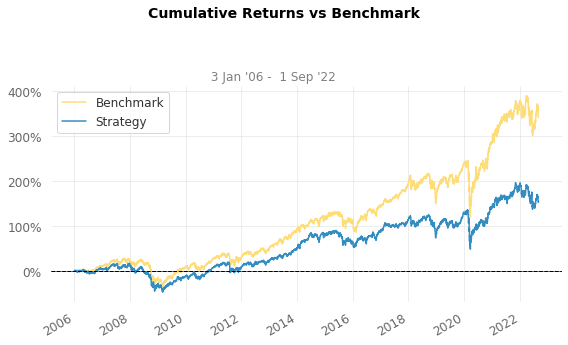

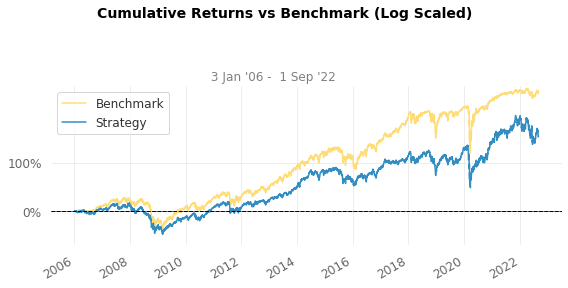

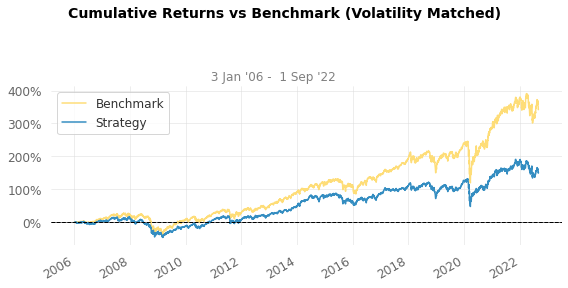

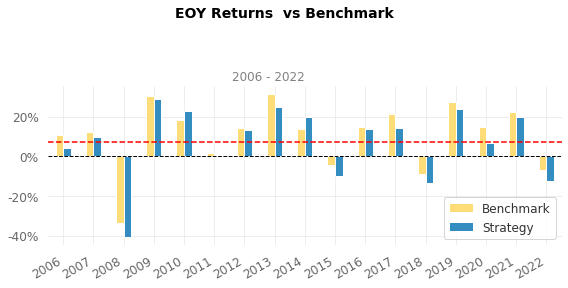

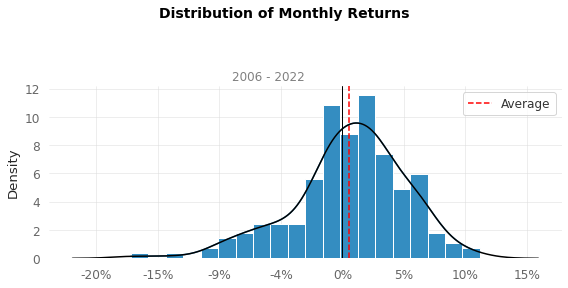

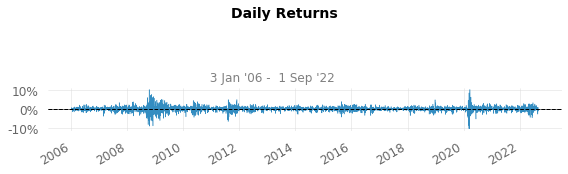

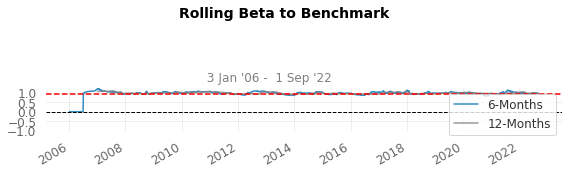

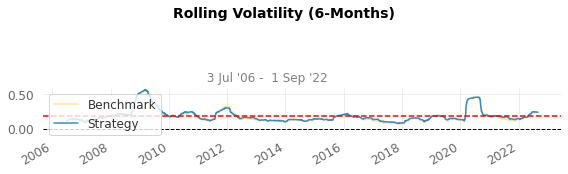

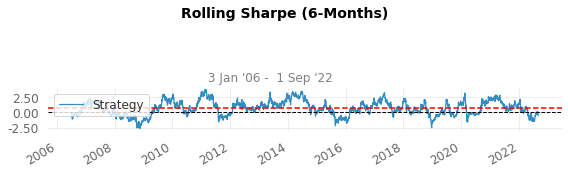

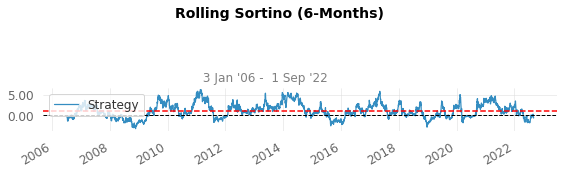

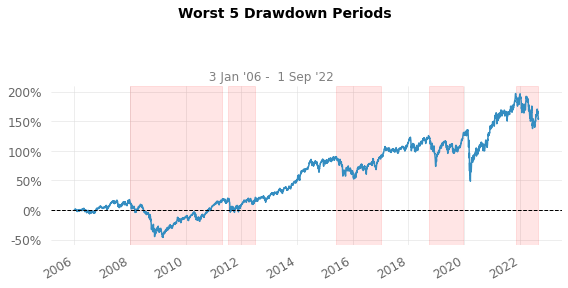

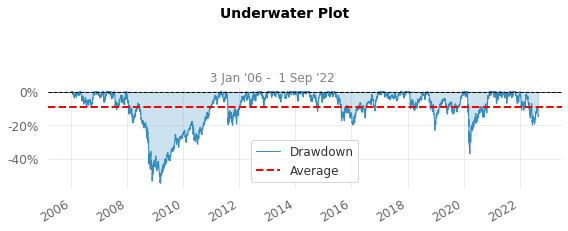

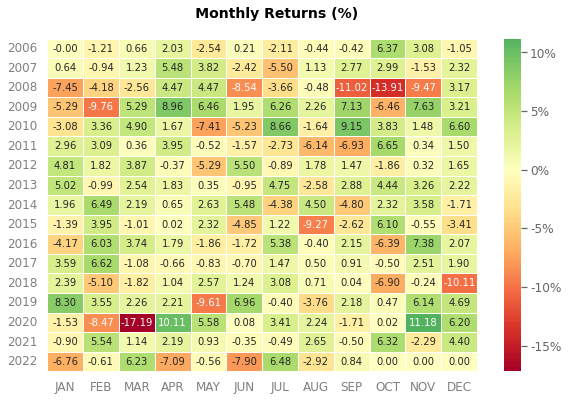

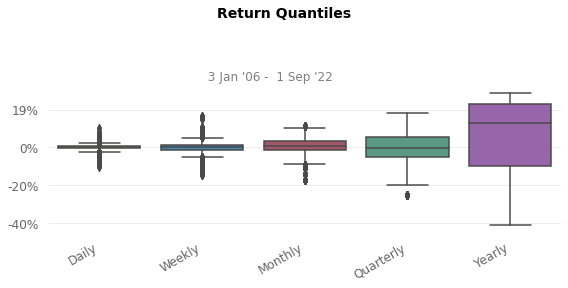

In [33]:
quantstats.reports.full(returns=myasset, benchmark=benchmark1)

#### Benchmark2 : S&P500

In [34]:
bm_engine = BacktestEngine(yfinance_list=['SPY'])
equal_weight = EqualWeightGenerator(bm_engine.cache)
bm_engine.run_backtest(target_generator=equal_weight, sdate=start_date, edate=end_date, transaction_cost=cost)
benchmark2 = bm_engine.asset_df.sum(axis=1)
benchmark2

[__init__] is executed in 2.27 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-09-01 00:00:00
=== date:2022-09-01 00:00:00 / total_asset:4.315 / time elapsed:3.0 ===date:2008-07-31 00:00:00 / total_asset:1.048 / time elapsed:0.9 === time elapsed:1.3 === total_asset:1.874 / time elapsed:1.8 === === ===total_asset:4.861 / time elapsed:2.8 ===
[run_backtest] is executed in 3.15 seconds


2006-01-03    0.999000
2006-01-04    1.003731
2006-01-05    1.004362
2006-01-06    1.012720
2006-01-09    1.015322
                ...   
2022-08-26    4.411644
2022-08-29    4.382473
2022-08-30    4.334363
2022-08-31    4.301382
2022-09-01    4.314880
Length: 4196, dtype: float64

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2022-09-01  2022-09-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          155.17%     331.92%
CAGR﹪                     5.78%       9.17%

Sharpe                     0.38        0.54
Prob. Sharpe Ratio         93.66%      98.61%
Smart Sharpe               0.34        0.49
Sortino                    0.52        0.76
Smart Sortino              0.47        0.69
Sortino/√2                 0.37        0.54
Smart Sortino/√2           0.33        0.49
Omega                      1.07        1.07

Max Drawdown               -54.43%     -55.19%
Longest DD Days            1217        1772
Volatility (ann.)          20.62%      19.9%
R^2                        0.86        0.86
Information Ratio          -0.02       -0.02
Calmar                     0.11      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-12-27,2009-03-09,2011-04-27,1217,-54.431627,-50.946498
2,2020-02-13,2020-03-23,2020-12-04,295,-36.941458,-32.026979
3,2018-09-24,2018-12-24,2019-12-18,450,-23.051119,-19.359891
4,2011-07-08,2011-10-03,2012-07-03,361,-20.026631,-18.934705
5,2021-11-09,2022-06-16,2022-09-01,296,-19.912392,-18.464649


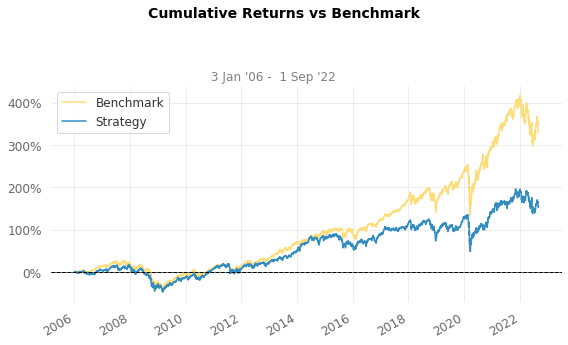

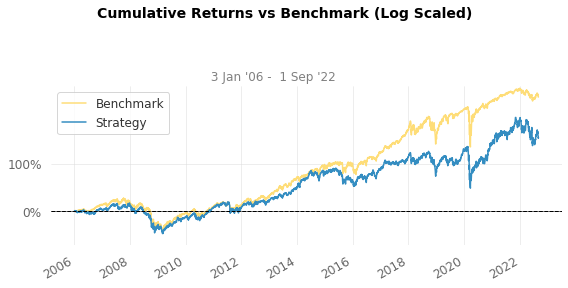

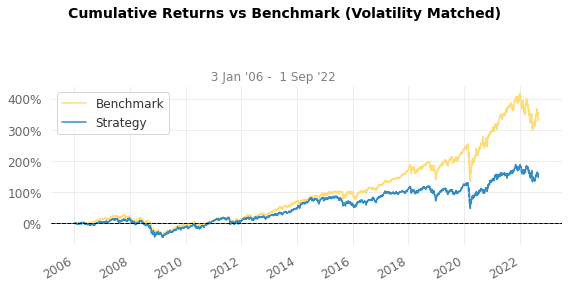

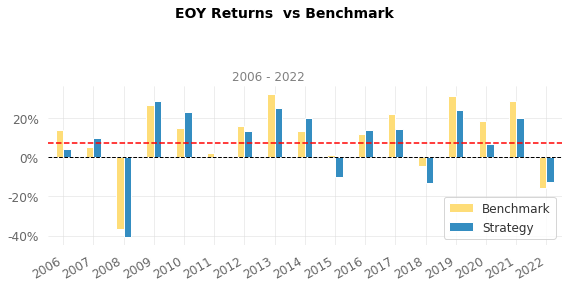

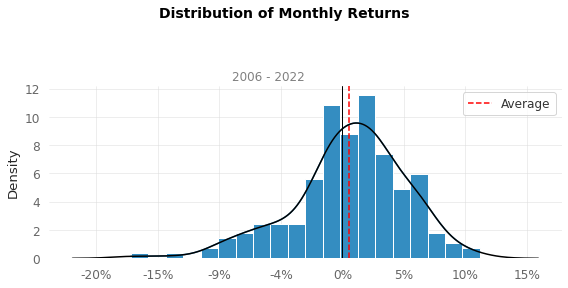

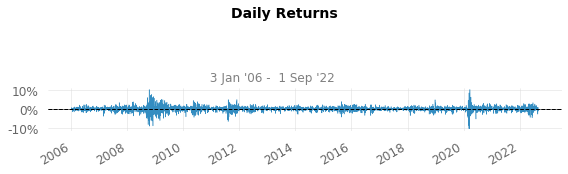

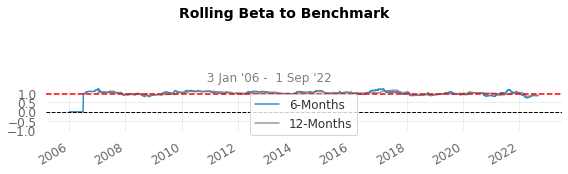

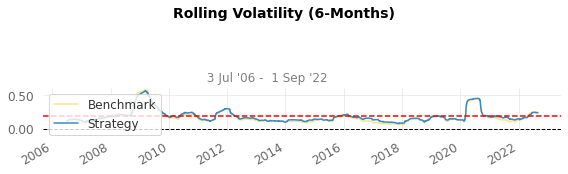

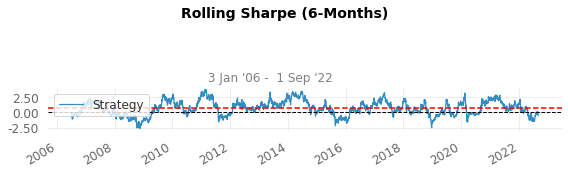

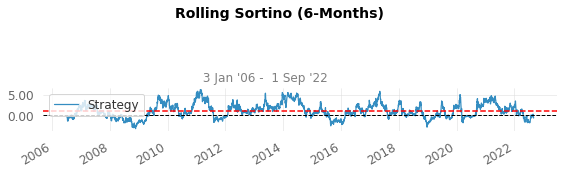

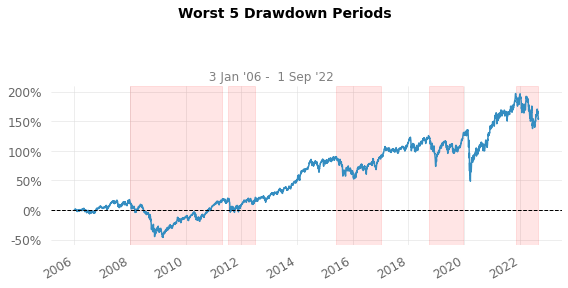

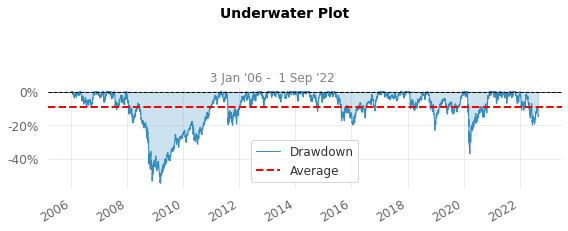

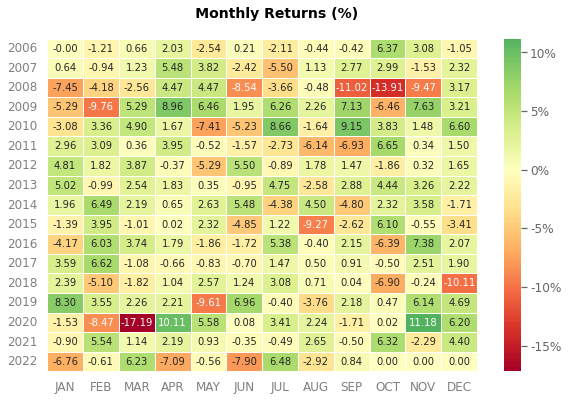

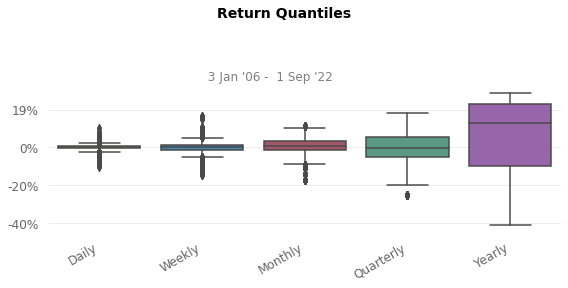

In [35]:
quantstats.reports.full(returns=myasset, benchmark=benchmark2)

#### strategy weight flow

In [36]:
historical_portfolio = engine.asset_df
weight_historical_portfolio = pd.DataFrame(index=historical_portfolio.index, columns=historical_portfolio.columns)
for date in historical_portfolio.index:
    for ticker in historical_portfolio.columns:
        weight_historical_portfolio.loc[date,ticker] = historical_portfolio.loc[date,ticker]/historical_portfolio.loc[date].sum(axis=0)
weight_historical_portfolio

,cash,XLY,XLK,XLU,SPY,XLE,XLP,XLF,XLV,XLI,XLB,XBI,XME,XPH
2006-01-03,0.0,0.2,0.0,0.2,0.0,0.0,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0
2006-01-04,0.0,0.199586,0.0,0.199717,0.0,0.0,0.200086,0.199219,0.201392,0.0,0.0,0.0,0.0,0.0
2006-01-05,0.0,0.200161,0.0,0.198798,0.0,0.0,0.199457,0.200294,0.201291,0.0,0.0,0.0,0.0,0.0
2006-01-06,0.0,0.200374,0.0,0.199506,0.0,0.0,0.198898,0.200053,0.20117,0.0,0.0,0.0,0.0,0.0
2006-01-09,0.0,0.201769,0.0,0.19763,0.0,0.0,0.199188,0.199965,0.201449,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-26,0.0,0.194259,0.0,0.203796,0.0,0.0,0.196516,0.201005,0.0,0.0,0.0,0.0,0.0,0.204424
2022-08-29,0.0,0.194511,0.0,0.205775,0.0,0.0,0.197505,0.200902,0.0,0.0,0.0,0.0,0.0,0.201306
2022-08-30,0.0,0.19458,0.0,0.205125,0.0,0.0,0.197732,0.202145,0.0,0.0,0.0,0.0,0.0,0.200418
2022-08-31,0.0,0.193858,0.0,0.20505,0.0,0.0,0.197745,0.201876,0.0,0.0,0.0,0.0,0.0,0.201471


<AxesSubplot:>

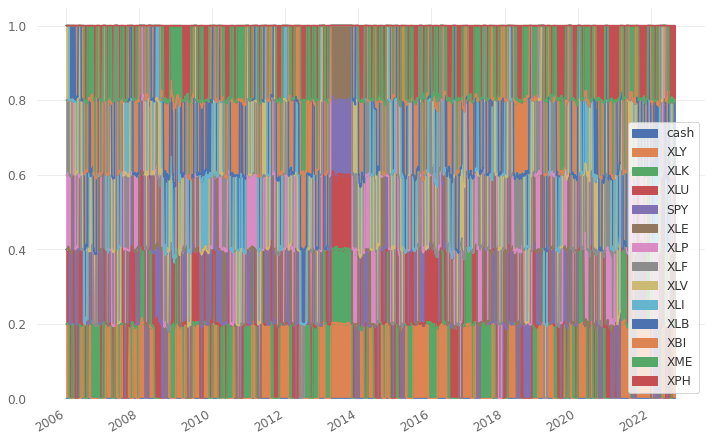

In [37]:
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)
weight_historical_portfolio.plot.area()